In [1]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rcParams['font.family'] = 'IPAexGothic'
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
### データファイルの読込
df_mig = pd.read_csv('./data/00200523_migration.csv', parse_dates=['datetime'])
df_pop = pd.read_csv('./data/00200241_population.csv', parse_dates=['datetime'])
df_wag = pd.read_csv('./data/00450091_wage.csv', parse_dates=['datetime'])
df_idt = pd.read_csv('./data/00550010_industrial.csv', parse_dates=['datetime'])
df_ret = pd.read_csv('./data/00550020_retail.csv', parse_dates=['datetime'])
pd.set_option("display.max_columns", 100)
df_mig.head(3)

,datetime,prefecture,mig_in,mig_out,mig_internal
0,2005-04-01,北海道,11705,13894,52526
1,2005-04-01,青森県,4230,6603,5525
2,2005-04-01,岩手県,4082,5984,4840


In [3]:
### データの前処理(1):月次データ化
df_mig_month = df_mig

df_list = []
for prefecture in df_pop['prefecture'].unique():
    df_tmp = df_pop[df_pop['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1MS').interpolate()
    df_tmp['prefecture'] = prefecture
    df_tmp.reset_index(inplace=True)
    df_list.append(df_tmp)
df_pop_month = pd.concat(df_list)

df_list = []
for prefecture in df_wag['prefecture'].unique():
    df_tmp = df_wag[df_wag['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1MS').interpolate()
    df_tmp['prefecture'] = prefecture
    df_tmp.reset_index(inplace=True)
    df_list.append(df_tmp)
df_wag_month = pd.concat(df_list)

df_list = []
for prefecture in df_idt['prefecture'].unique():
    df_tmp = df_idt[df_idt['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1MS').interpolate()
    df_tmp['prefecture'] = prefecture
    df_tmp.reset_index(inplace=True)
    df_list.append(df_tmp)
df_idt_month = pd.concat(df_list)

df_list = []
for prefecture in df_ret['prefecture'].unique():
    df_tmp = df_ret[df_ret['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1MS').interpolate()
    df_tmp['prefecture'] = prefecture
    df_tmp.reset_index(inplace=True)
    df_list.append(df_tmp)
df_ret_month = pd.concat(df_list)

In [4]:
### データの前処理(2):データ結合
dt_all_start = datetime.datetime.strptime('2008-01-01', '%Y-%m-%d')
dt_all_end = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d')
df_all = df_mig_month[((df_mig_month['datetime'] >= dt_all_start) & (df_mig_month['datetime'] <= dt_all_end))]
df_all = df_all.merge(df_pop_month, how='left')
df_all = df_all.merge(df_wag_month, how='left')
df_all = df_all.merge(df_idt_month, how='left')
df_all = df_all.merge(df_ret_month, how='left')
df_all.dropna(inplace=True)
df_all.reset_index(drop=True, inplace=True)
df_all.head(3)

,datetime,prefecture,mig_in,mig_out,mig_internal,pop_male,pop_female,pop_sum,pop_households,wag_age,wag_salary,wag_bonus,wag_workers,idt_offices,idt_employees,idt_salaries,idt_costs,idt_sales,ret_offices,ret_employees,ret_sales
0,2008-01-01,北海道,2310,3525,10230,2648735.0,2923035.0,5571770.0,2618005.0,41.6,299300.0,767600.0,814020.0,6618.0,185625.0,6.255000e+11,3.893719e+12,5.917424e+12,58041.8,462157.4,1.735049e+13
1,2008-01-01,青森県,916,1464,1042,680654.0,749889.0,1430543.0,565347.0,40.9,247600.0,552900.0,204810.0,1829.0,63036.0,1.946430e+11,9.221590e+11,1.649446e+12,18200.4,117196.6,3.215000e+12
2,2008-01-01,岩手県,924,1130,1161,657304.0,709348.0,1366652.0,499351.0,41.9,255400.0,547300.0,213920.0,2696.0,98655.0,3.379460e+11,1.676235e+12,2.528404e+12,17462.2,108503.2,3.121844e+12


In [5]:
### データの前処理(3):ラグデータ化
df_list1 = []
df_list2 = []
for prefecture in df_all['prefecture'].unique():
    df_tmp = df_all[df_all['prefecture'] == prefecture]
    df_tmp1 = df_tmp.shift(1)
    df_list1.append(df_tmp1)
    df_tmp2 = df_tmp.shift(2)
    df_list2.append(df_tmp2)
df_all_lag1 = pd.concat(df_list1)
df_all_lag1.rename(columns=lambda x: x + '_lag1', inplace=True)
df_all_lag = pd.concat([df_all.iloc[:, 0:3], df_all_lag1.iloc[:,2:24]], axis=1)
df_all_lag2 = pd.concat(df_list2)
df_all_lag2.rename(columns=lambda x: x + '_lag2', inplace=True)
df_all_lag = pd.concat([df_all_lag, df_all_lag2.iloc[:,2:24]], axis=1)
df_all_lag.dropna(inplace=True)
df_all_lag.reset_index(drop=True, inplace=True)
df_all_lag.head(5)

,datetime,prefecture,mig_in,mig_in_lag1,mig_out_lag1,mig_internal_lag1,pop_male_lag1,pop_female_lag1,pop_sum_lag1,pop_households_lag1,wag_age_lag1,wag_salary_lag1,wag_bonus_lag1,wag_workers_lag1,idt_offices_lag1,idt_employees_lag1,idt_salaries_lag1,idt_costs_lag1,idt_sales_lag1,ret_offices_lag1,ret_employees_lag1,ret_sales_lag1,mig_in_lag2,mig_out_lag2,mig_internal_lag2,pop_male_lag2,pop_female_lag2,pop_sum_lag2,pop_households_lag2,wag_age_lag2,wag_salary_lag2,wag_bonus_lag2,wag_workers_lag2,idt_offices_lag2,idt_employees_lag2,idt_salaries_lag2,idt_costs_lag2,idt_sales_lag2,ret_offices_lag2,ret_employees_lag2,ret_sales_lag2
0,2008-03-01,北海道,8759,2406.0,3925.0,11941.0,2.647318e+06,2.922101e+06,5.569419e+06,2.619600e+06,41.633333,297550.000000,761608.333333,816202.500000,6577.833333,184915.666667,6.220301e+11,3.847937e+12,5.857851e+12,58025.616667,462021.100000,1.731142e+13,2310.0,3525.0,10230.0,2648735.0,2923035.0,5571770.0,2618005.0,41.6,299300.0,767600.0,814020.0,6618.0,185625.0,6.255000e+11,3.893719e+12,5.917424e+12,58041.8,462157.4,1.735049e+13
1,2008-03-01,青森県,3734,1016.0,1537.0,957.0,6.800598e+05,7.493778e+05,1.429438e+06,5.655498e+05,41.008333,246833.333333,545241.666667,203283.333333,1813.750000,62639.166667,1.932893e+11,9.100428e+11,1.633442e+12,18161.100000,117027.900000,3.207058e+12,916.0,1464.0,1042.0,680654.0,749889.0,1430543.0,565347.0,40.9,247600.0,552900.0,204810.0,1829.0,63036.0,1.946430e+11,9.221590e+11,1.649446e+12,18200.4,117196.6,3.215000e+12
2,2008-03-01,岩手県,3369,1057.0,1190.0,1070.0,6.567920e+05,7.089061e+05,1.365698e+06,4.994862e+05,41.933333,255316.666667,547475.000000,213195.833333,2676.916667,97911.166667,3.336738e+11,1.643227e+12,2.485218e+12,17423.883333,108371.716667,3.116324e+12,924.0,1130.0,1161.0,657304.0,709348.0,1366652.0,499351.0,41.9,255400.0,547300.0,213920.0,2696.0,98655.0,3.379460e+11,1.676235e+12,2.528404e+12,17462.2,108503.2,3.121844e+12
3,2008-03-01,宮城県,10217,2546.0,2781.0,4478.0,1.135471e+06,1.199072e+06,2.334543e+06,8.922222e+05,41.125000,300650.000000,736425.000000,330714.166667,3444.250000,124256.333333,4.613415e+11,2.177089e+12,3.489153e+12,28741.400000,225741.783333,1.034831e+13,2336.0,2526.0,3485.0,1135696.0,1199178.0,2334874.0,891573.0,41.1,301700.0,739500.0,332470.0,3467.0,124885.0,4.648840e+11,2.215718e+12,3.538700e+12,28799.6,226099.8,1.036777e+13
4,2008-03-01,秋田県,2518,702.0,978.0,614.0,5.350522e+05,5.947635e+05,1.129816e+06,4.168832e+05,42.108333,252116.666667,277016.666667,183367.500000,2351.916667,74122.500000,2.337344e+11,9.421268e+11,1.524924e+12,15292.766667,91227.266667,2.386528e+12,604.0,895.0,613.0,535577.0,595246.0,1130823.0,416787.0,42.1,252500.0,252500.0,183900.0,2369.0,74699.0,2.365540e+11,9.660220e+11,1.555844e+12,15321.4,91360.4,2.393010e+12


In [7]:
### データの前処理(4):データスケーリング
df_all_list = list()
df_all_list.append(df_all_lag['datetime'])
df_all_list.append(df_all_lag['prefecture'])
df_all_list.append(df_all_lag['mig_in'])
for i in range(3, df_all_lag.shape[1]):
    sc = StandardScaler()
    a = df_all_lag.iloc[:, i]
    a = np.array(a, dtype='float32').reshape(-1, 1)
    sc.partial_fit(a)
    a = sc.transform(a)
    a = pd.DataFrame(a, columns=[df_all_lag.columns[i]])
    a = df_all_list.append(a)
df_all_sc = pd.concat(df_all_list, 1)
df_all_sc.head(3)

,datetime,prefecture,mig_in,mig_in_lag1,mig_out_lag1,mig_internal_lag1,pop_male_lag1,pop_female_lag1,pop_sum_lag1,pop_households_lag1,wag_age_lag1,wag_salary_lag1,wag_bonus_lag1,wag_workers_lag1,idt_offices_lag1,idt_employees_lag1,idt_salaries_lag1,idt_costs_lag1,idt_sales_lag1,ret_offices_lag1,ret_employees_lag1,ret_sales_lag1,mig_in_lag2,mig_out_lag2,mig_internal_lag2,pop_male_lag2,pop_female_lag2,pop_sum_lag2,pop_households_lag2,wag_age_lag2,wag_salary_lag2,wag_bonus_lag2,wag_workers_lag2,idt_offices_lag2,idt_employees_lag2,idt_salaries_lag2,idt_costs_lag2,idt_sales_lag2,ret_offices_lag2,ret_employees_lag2,ret_sales_lag2
0,2008-03-01,北海道,8759,-0.261309,-0.054926,1.014423,1.025891,1.175068,1.101294,1.203964,-0.269587,0.077895,0.340591,0.640366,0.424364,0.161072,-0.110705,-0.012639,-0.047847,1.010020,0.749923,0.266476,-0.275017,-0.122390,0.770474,1.027689,1.176822,1.103065,1.204939,-0.298993,0.132761,0.374063,0.636772,0.427283,0.163703,-0.107556,-0.003746,-0.040272,1.010476,0.752381,0.267058
1,2008-03-01,青森県,3734,-0.458123,-0.456663,-0.574192,-0.497591,-0.486926,-0.492384,-0.477181,-1.289705,-1.510322,-1.121188,-0.435228,-0.675833,-0.691705,-0.714477,-0.673534,-0.680838,-0.441307,-0.412819,-0.293304,-0.472440,-0.469415,-0.561934,-0.497292,-0.486690,-0.492117,-0.477018,-1.438696,-1.485538,-1.069818,-0.432070,-0.673024,-0.689655,-0.712999,-0.670904,-0.678784,-0.440632,-0.412608,-0.293317
2,2008-03-01,岩手県,3369,-0.452318,-0.515039,-0.557849,-0.515610,-0.517885,-0.516921,-0.531251,0.220069,-1.244662,-1.106100,-0.417833,-0.476497,-0.445712,-0.516781,-0.508600,-0.553207,-0.468146,-0.441993,-0.296905,-0.471307,-0.525653,-0.544677,-0.515384,-0.517724,-0.516728,-0.531096,0.189458,-1.241385,-1.107479,-0.416086,-0.473825,-0.441706,-0.511629,-0.501603,-0.547287,-0.467519,-0.441967,-0.297010


In [8]:
### データ前処理(5):学習用データ化
dt_train_start = datetime.datetime.strptime('2008-03-01', '%Y-%m-%d')
dt_train_end = datetime.datetime.strptime('2012-12-01', '%Y-%m-%d')
dt_validation_start = datetime.datetime.strptime('2013-01-01', '%Y-%m-%d')
dt_validation_end = datetime.datetime.strptime('2013-12-01', '%Y-%m-%d')
df_train = df_all_sc[((df_all_sc['datetime'] >= dt_train_start) & (df_all_sc['datetime'] <= dt_train_end))]
df_train_rand = df_train.reindex(np.random.permutation(df_train.index)).reset_index(drop=True)
train_x = np.array(df_train_rand.iloc[:, 3:].as_matrix(), dtype='float32')
train_y = np.array(df_train_rand.iloc[:, 2].as_matrix(), dtype='float32')
df_validation = df_all_sc[((df_all_sc['datetime'] >= dt_validation_start) & (df_all_sc['datetime'] <= dt_validation_end))]
df_validation_rand = df_validation.reindex(np.random.permutation(df_validation.index)).reset_index(drop=True)
validation_x = np.array(df_validation_rand.iloc[:, 3:].as_matrix(), dtype='float32')
validation_y = np.array(df_validation_rand.iloc[:, 2].as_matrix(), dtype='float32')

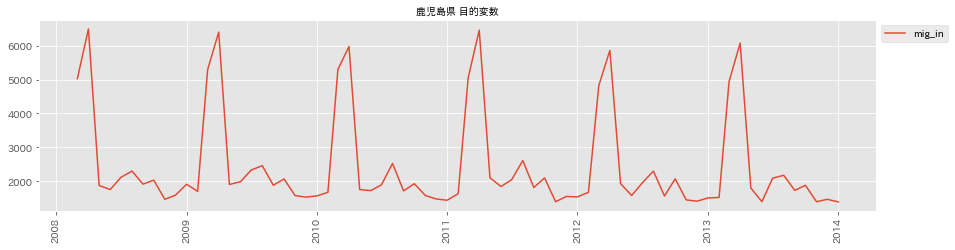

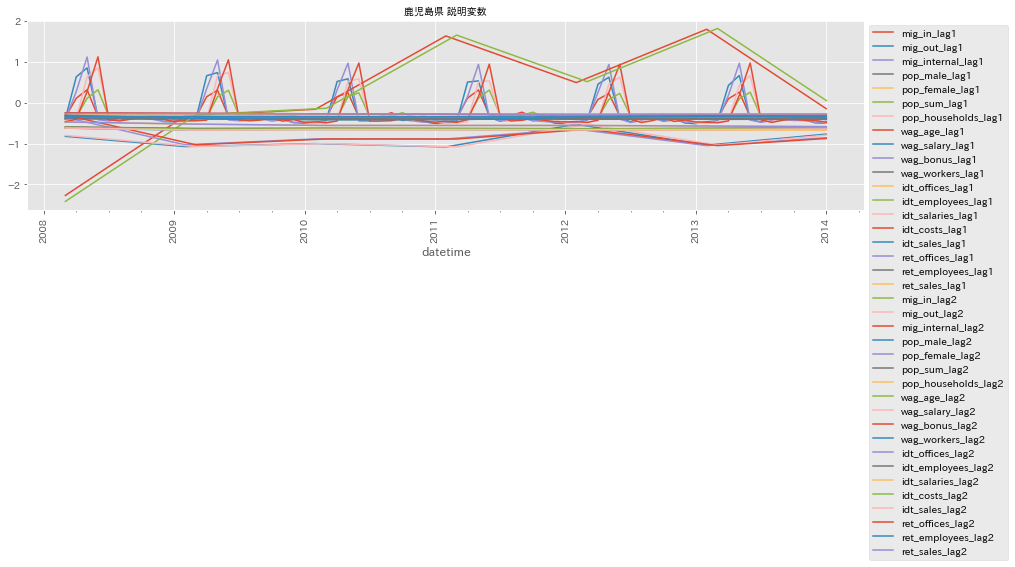

In [9]:
### 事前のデータ確認(サンプル)
prefecture = '鹿児島県'
df_tmp = df_all_sc[df_all_sc['prefecture'] == prefecture]
x = df_tmp['datetime']
y = df_tmp['mig_in']
fig = plt.figure(figsize=(15,3.5))
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title(prefecture + ' 目的変数', fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

df_tmp.set_index('datetime', inplace=True)
df_tmp = df_tmp.iloc[:, 2:]
fig = plt.figure(figsize=(15,3.5))
ax = fig.add_subplot(111)
df_tmp.plot(ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title(prefecture + ' 説明変数', fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import datasets
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [11]:
### DL学習設定
n_in = df_all_sc.shape[1] -3 # 19
n_hiddens = [200, 200]
n_out = 1
activation = 'relu'

def weight_variable(shape, name=None):
    return np.sqrt(2000.0 / shape[0]) * np.random.normal(size=shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)

model = Sequential()
for i, input_dim in enumerate(([n_in] + n_hiddens)[:-1]):
    model.add(Dense(n_hiddens[i], input_dim=input_dim,
                    kernel_initializer=weight_variable))
    model.add(BatchNormalization())
    model.add(Activation(activation))

model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('relu'))
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999),
              metrics=['mae'])

### DL学習
epochs = 500
batch_size = 30
hist = model.fit(train_x, train_y, epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(validation_x, validation_y),
                 callbacks=[early_stopping])

Train on 2726 samples, validate on 564 samples
Epoch 1/500
2726/2726 [==============================] - 1s 343us/step - loss: 63318742.5438 - mean_absolute_error: 4058.5689 - val_loss: 53022480.2686 - val_mean_absolute_error: 3688.7569
Epoch 2/500
2726/2726 [==============================] - 0s 105us/step - loss: 52612018.8153 - mean_absolute_error: 3543.5748 - val_loss: 41219147.8856 - val_mean_absolute_error: 3096.7431
Epoch 3/500
2726/2726 [==============================] - 0s 110us/step - loss: 41085688.4814 - mean_absolute_error: 2804.9412 - val_loss: 30378823.0319 - val_mean_absolute_error: 2424.7351
Epoch 4/500
2726/2726 [==============================] - 0s 106us/step - loss: 29817485.3504 - mean_absolute_error: 2071.0746 - val_loss: 20239914.8703 - val_mean_absolute_error: 1635.9516
Epoch 5/500
2726/2726 [==============================] - 0s 111us/step - loss: 23829826.5778 - mean_absolute_error: 1748.3193 - val_loss: 16515827.9189 - val_mean_absolute_error: 1416.3836
Epoch 6/

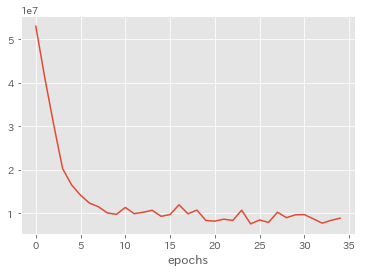

564/564 [==============================] - 0s 91us/step
[8851494.72074468, 1222.3219368576158]


In [12]:
### 学習過程の確認
val_loss = hist.history['val_loss']
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, label='loss')
plt.xlabel('epochs')
plt.show()

print(model.evaluate(validation_x, validation_y))

In [13]:
### モデルを用いた予測データの作成
train_x = np.array(df_train.iloc[:, 3:].as_matrix(), dtype='float32')
validation_x = np.array(df_validation.iloc[:, 3:].as_matrix(), dtype='float32')
pred_train = model.predict_proba(train_x) 
pred_validation = model.predict_proba(validation_x)
pred = np.concatenate([pred_train, pred_validation])
df_pred = pd.DataFrame(pred, columns=['mig_in_pred'])
df_pred = pd.concat([df_all_sc.iloc[:, 0:3], df_pred], axis=1)
df_pred.head(3)

,datetime,prefecture,mig_in,mig_in_pred
0,2008-03-01,北海道,8759,9435.920898
1,2008-03-01,青森県,3734,1641.234619
2,2008-03-01,岩手県,3369,840.116699


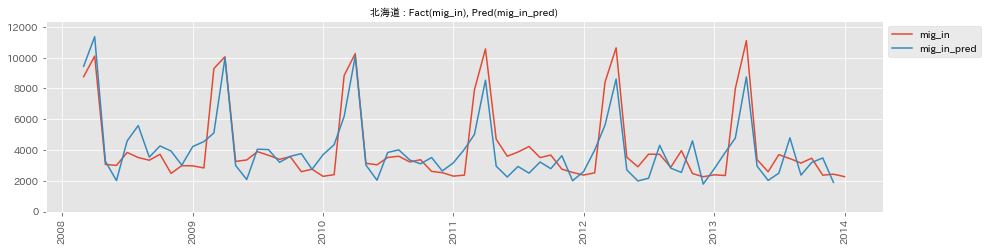

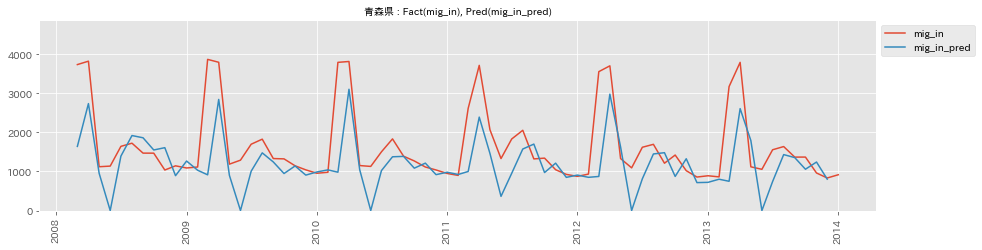

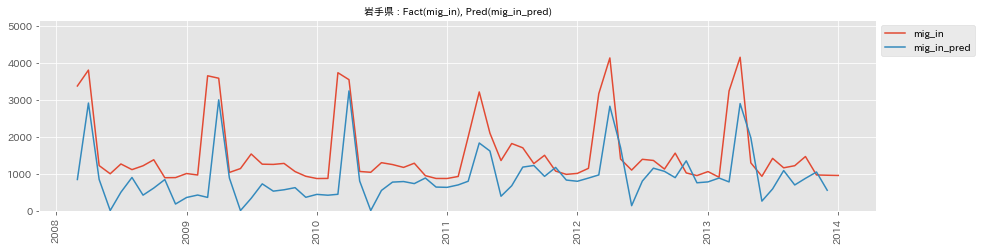

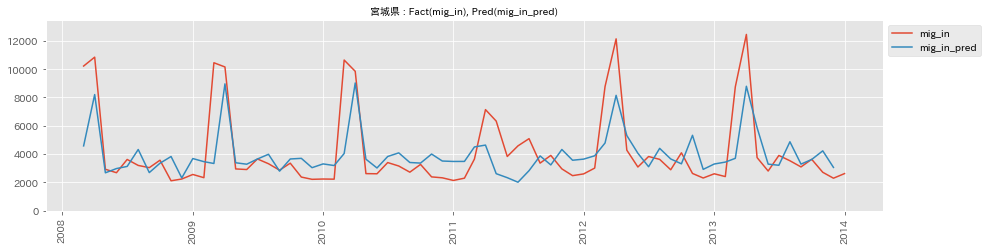

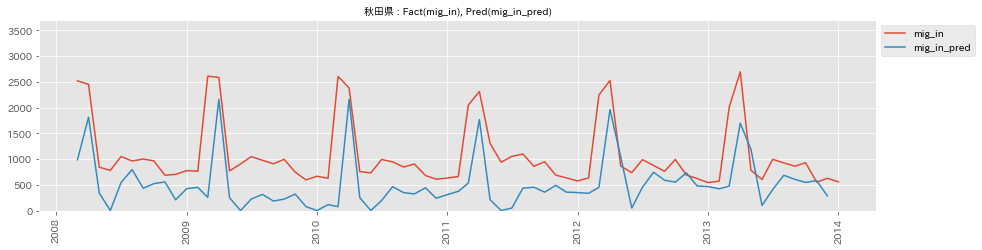

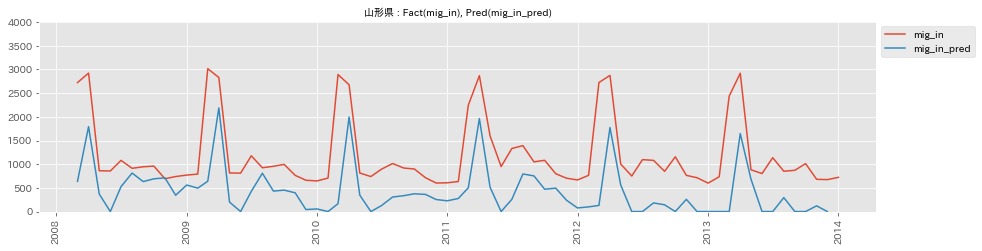

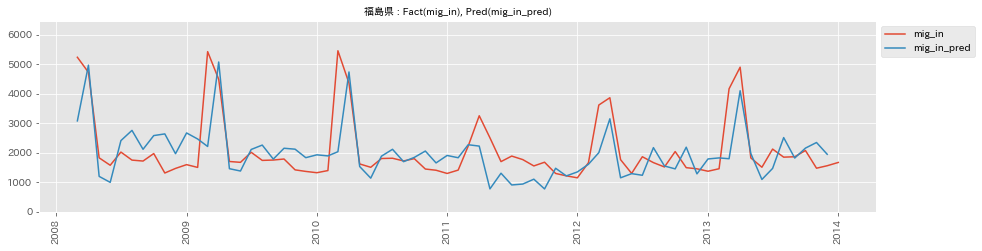

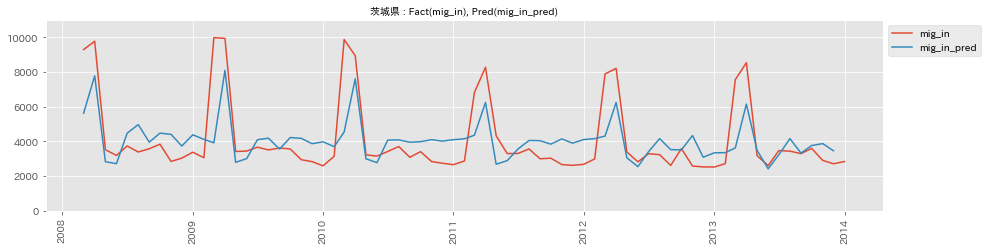

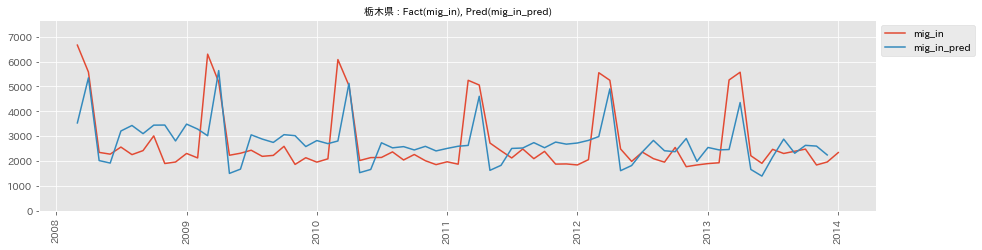

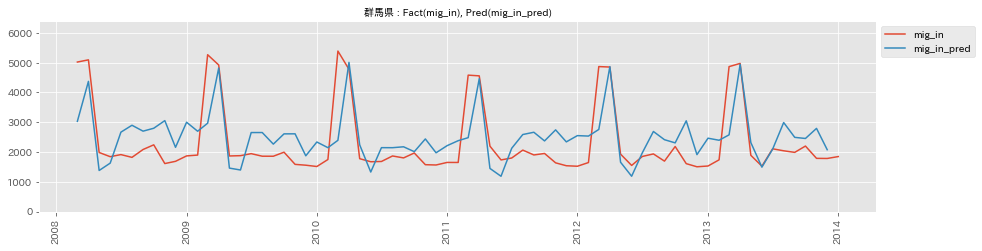

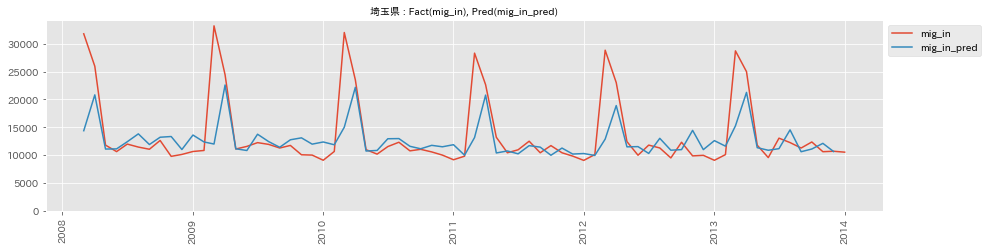

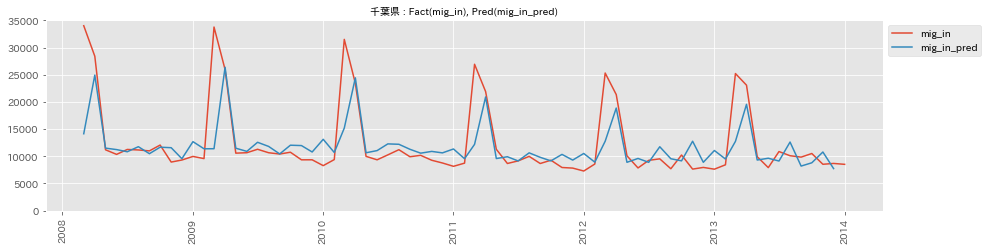

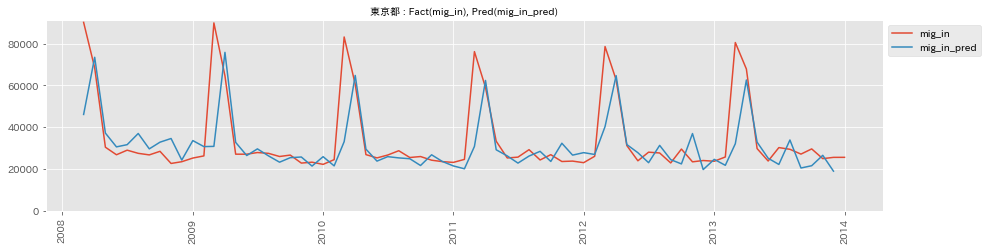

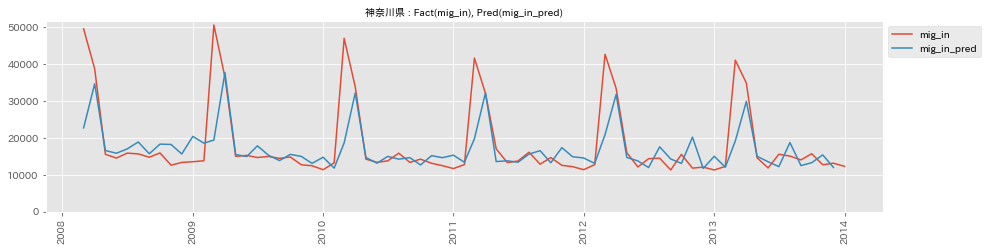

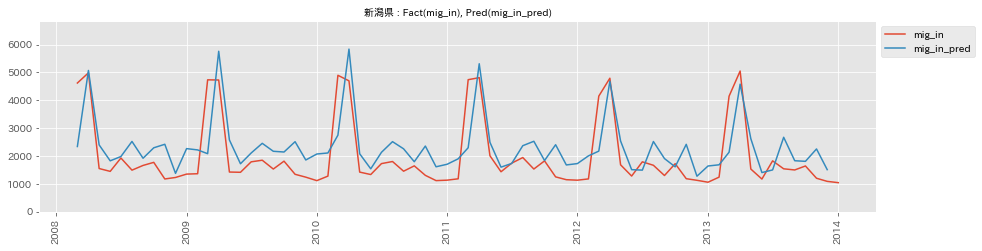

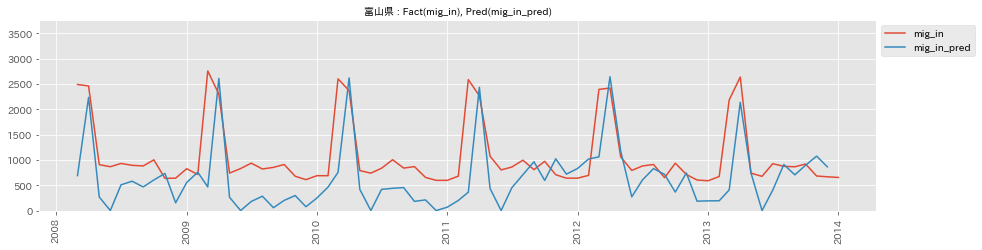

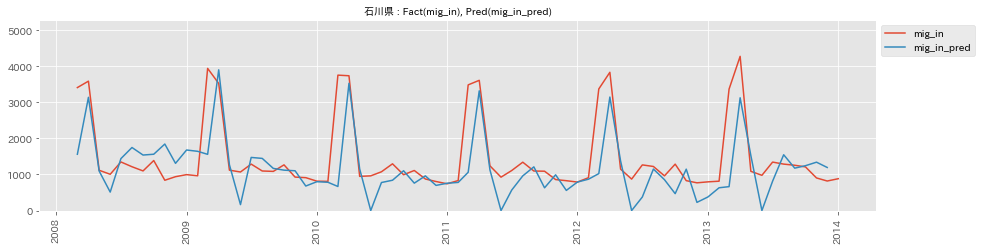

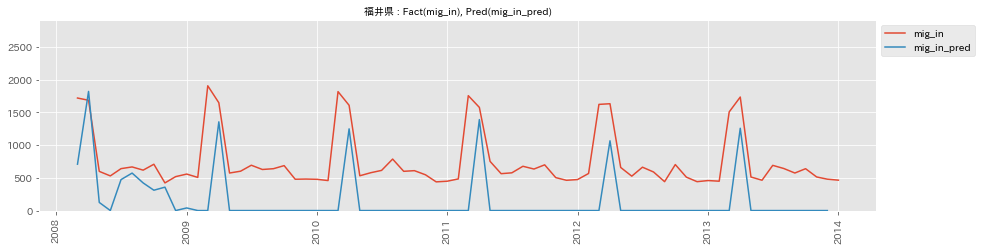

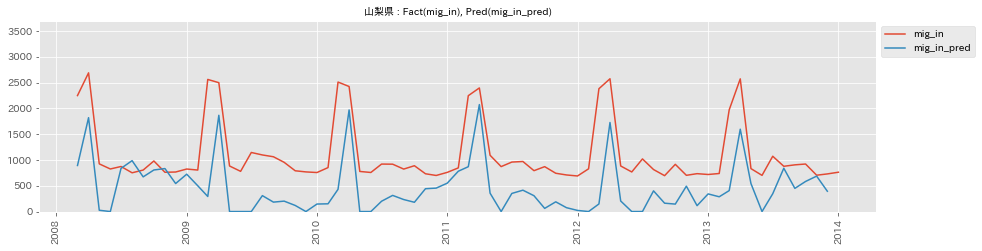

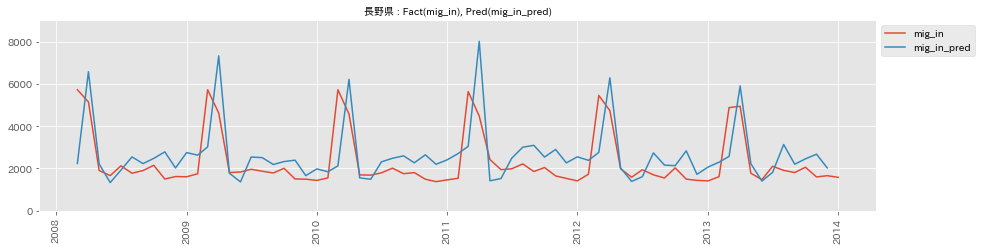

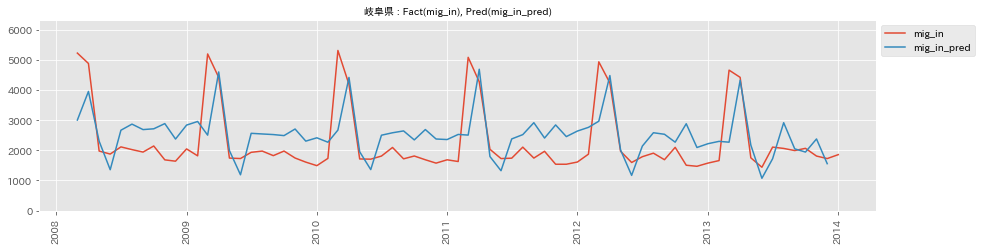

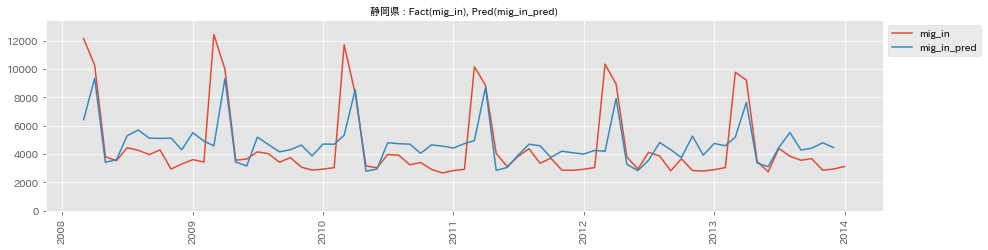

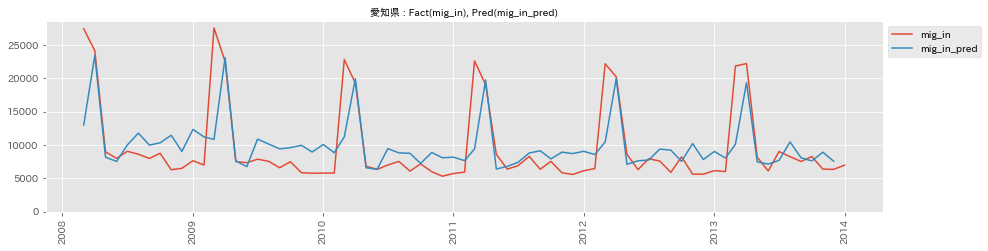

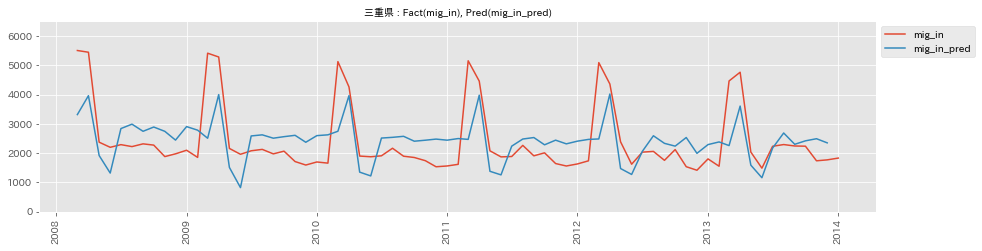

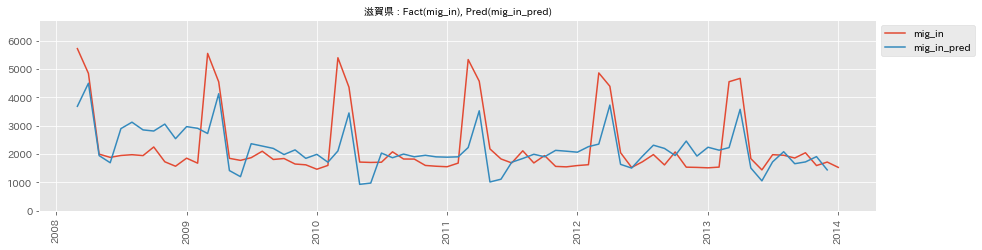

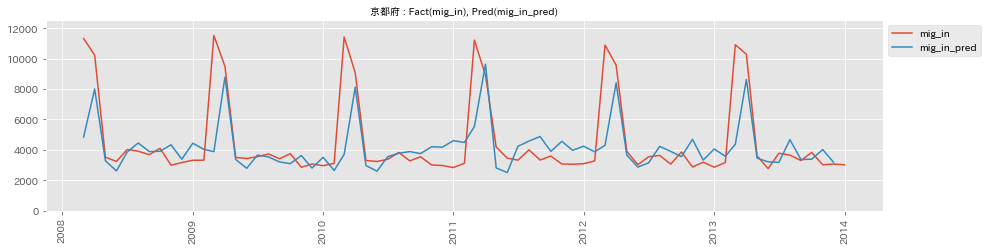

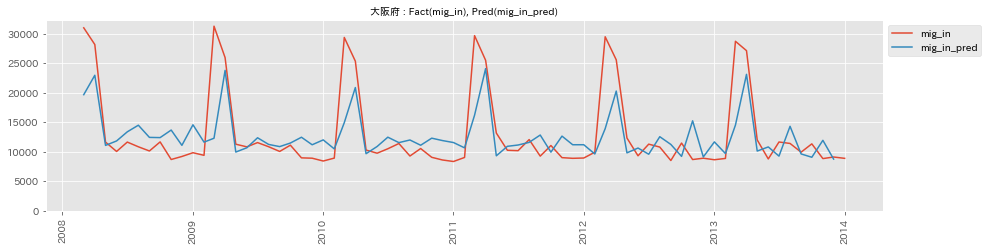

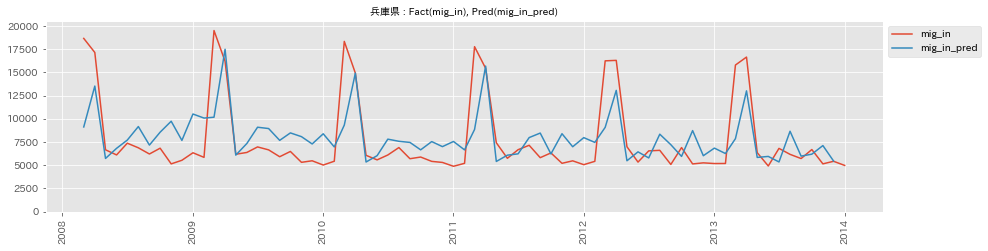

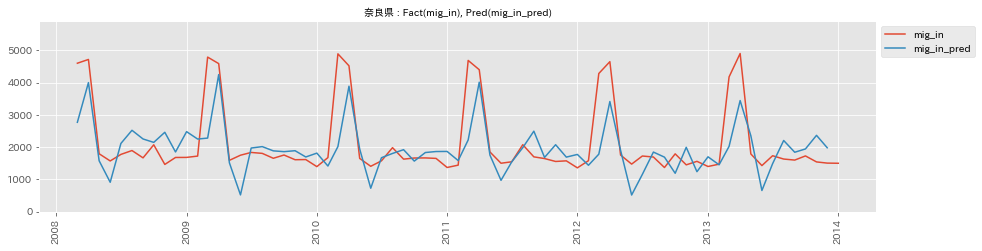

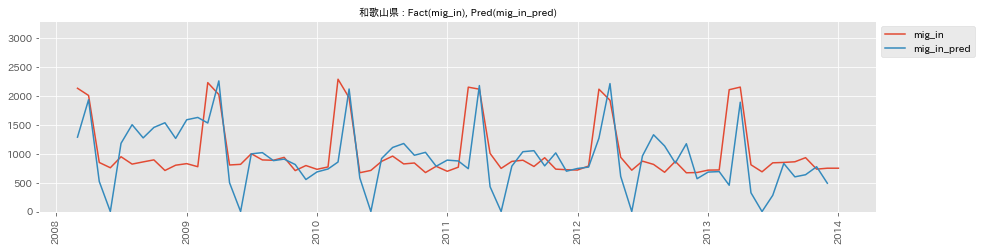

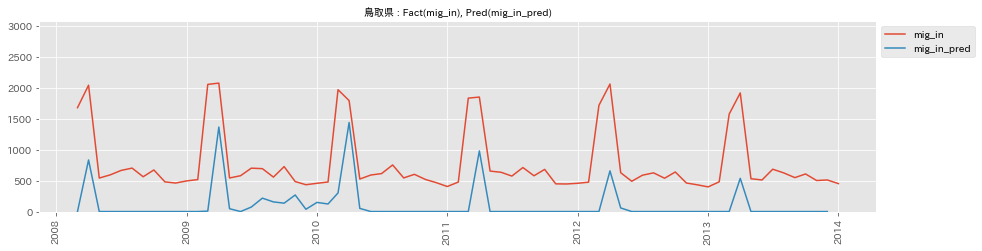

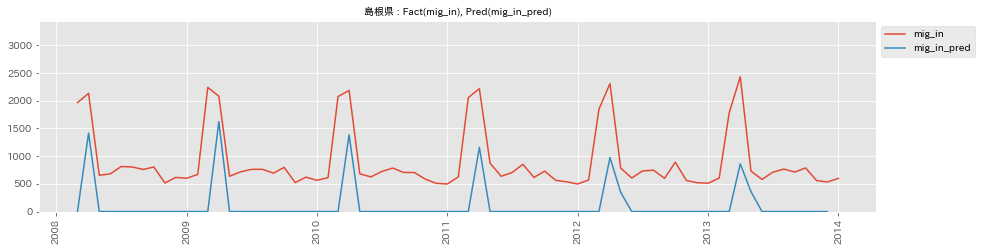

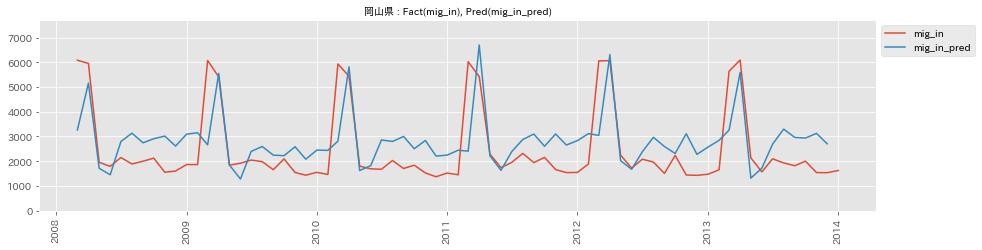

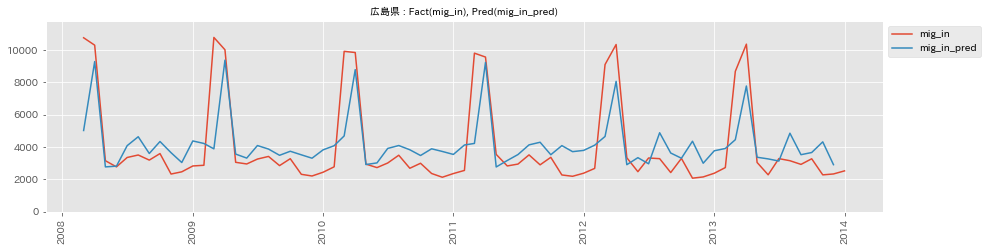

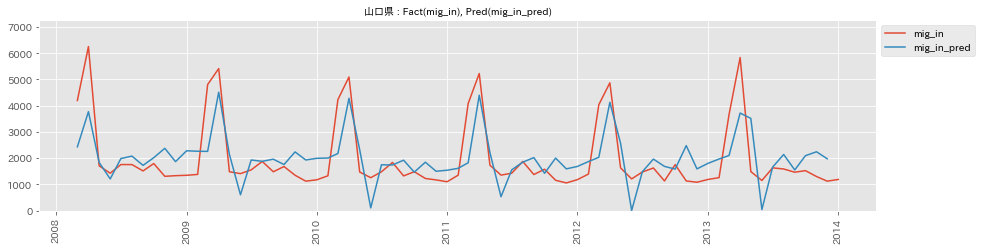

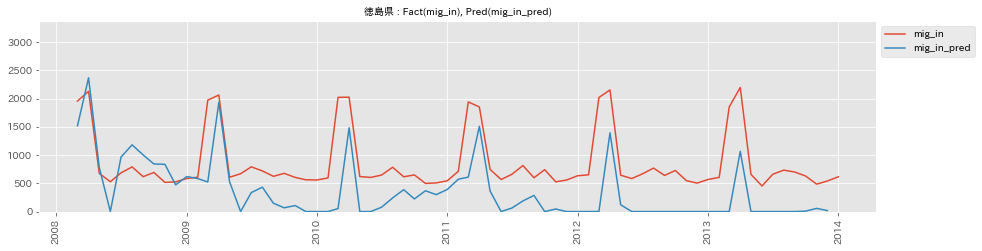

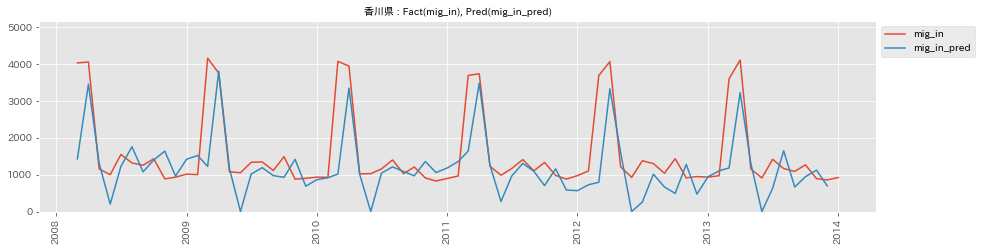

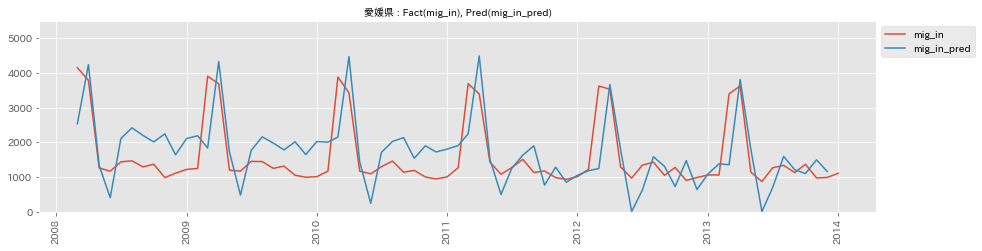

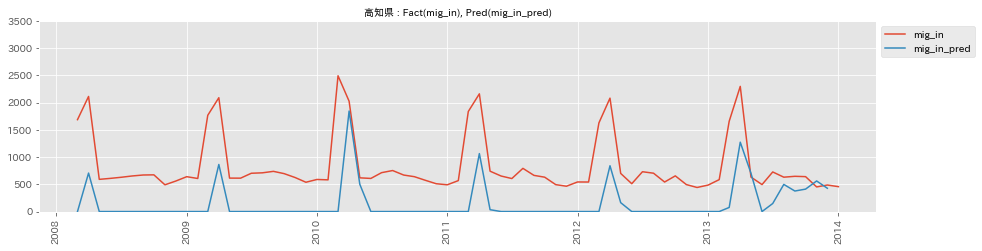

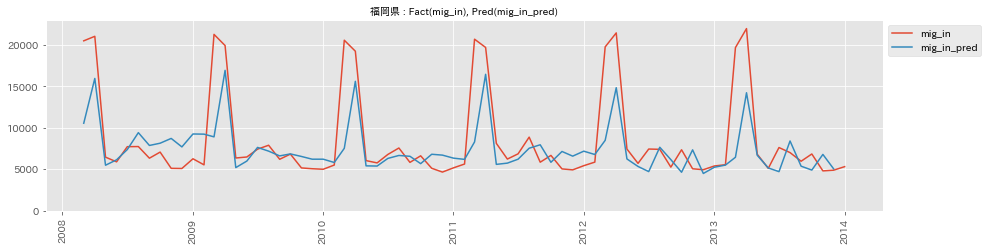

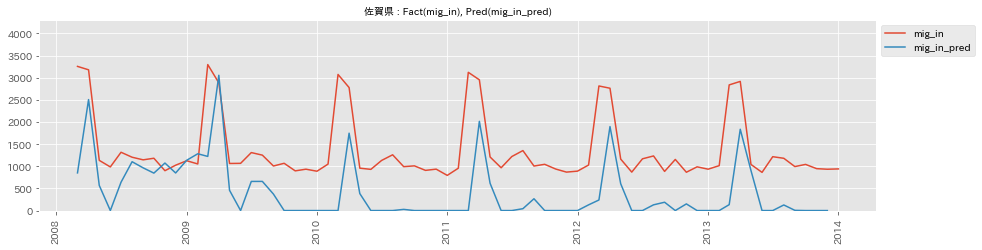

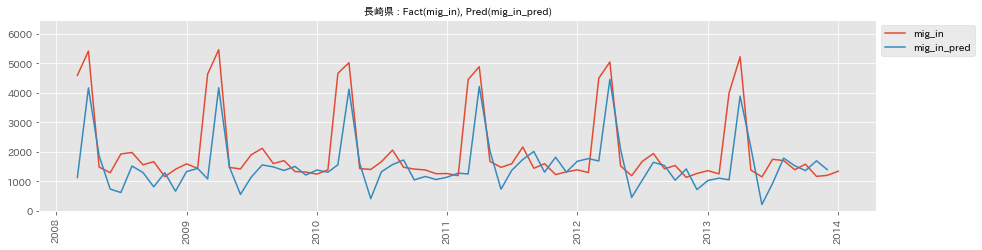

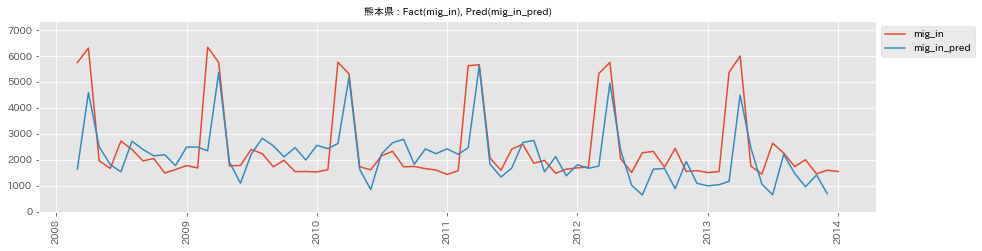

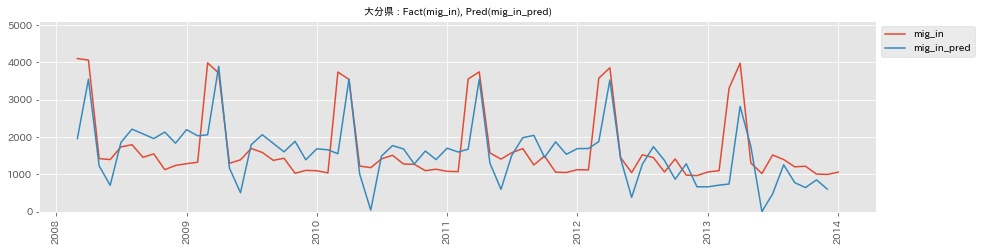

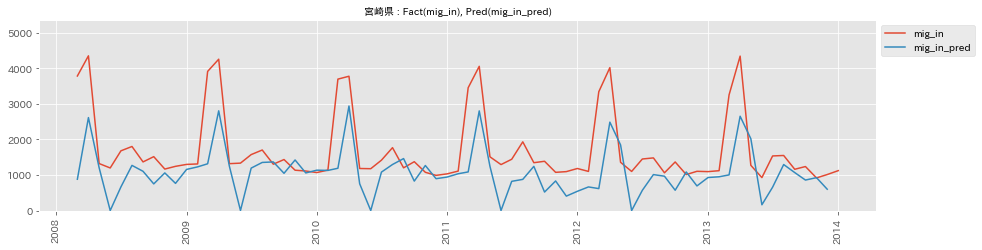

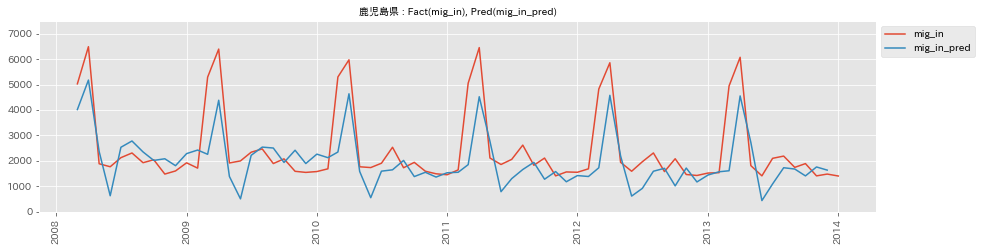

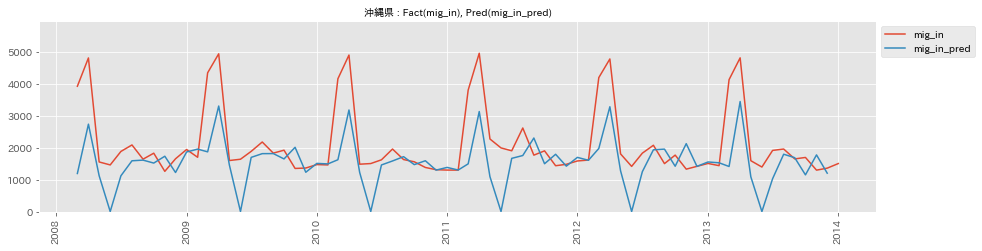

In [14]:
### 予測データの確認(可視化)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'IPAexGothic'
for prefecture in df_pred['prefecture'].unique():
    df_tmp = df_pred[df_pred['prefecture'] == prefecture]
    x = df_tmp['datetime']
    y1 = df_tmp['mig_in']
    y2 = df_tmp['mig_in_pred']
    fig = plt.figure(figsize=(15,3.5))
    ax = fig.add_subplot(111)
    ax.plot(x, y1)
    ax.plot(x, y2)
    plt.ylim(0, max(y1.max(), y2.max()) + 1000)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.set_title(prefecture + ' : Fact(mig_in), Pred(mig_in_pred)', fontsize=10)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()